- 项目内容：
    - 1、利用网络爬虫获取广州番禺区二手房信息
    - 2、进行数据预处理
    - 3、进行数据可视化
    - 4、构建机器学习房价预测模型
    - 5、预测房价

# 1、房屋信息的爬取

In [1]:
import requests
from bs4 import BeautifulSoup
# requests返回网页内容
res = requests.get(r'https://gz.esf.fang.com/house-a078/')
#res.text

# BeautifulSoup解析网页
soup = BeautifulSoup(res.text,'html.parser') # 使用 HTML.parser 解析器

In [3]:
def get_house(url):
    '获取页面中每个房子的信息'
    header = {
    'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36 Edg/126.0.0.0',
    'Cookie':'global_cookie=vep8fkk5r5cbqet1nhi7b3wv01ylxde7lid; __utmz=147393320.1718370118.5.3.utmcsr=search.fang.com|utmccn=(referral)|utmcmd=referral|utmcct=/; city=gz; __utma=147393320.717305635.1718291196.1718376220.1718414238.7; otherid=8a6d0a40f84c32f2a027a6fcf33a5122; __utmt_t0=1; __utmt_t1=1; __utmt_t2=1; csrfToken=9SLazy0sywzjZQI0Qws1oZAH; g_sourcepage=esf_fy%5Elb_pc; unique_cookie=U_jg0r8dno656mz299kzbko666z1clxfg0nid*1; __utmc=147393320; __utmb=147393320.24.10.1718414238'
    }
    information = {} # 存储房屋所有信息
    res = requests.get(url,headers=header)
    soup = BeautifulSoup(res.text,'html.parser')
    
    # 获取户型、建筑面积、单价、朝向、楼层、装修情况
    houses = soup.select('.tab-cont-right .trl-item1') 
    for i in range(len(houses)):
        me = houses[i].text.strip().split(' ')
        if i==1:
            me = houses[i].text.strip().split(' ')
            str1=me[0][-4:]             #str1为键
            str2=me[0][:-4]             #str2为值
            information[str1] = str2.strip()
        elif i==0 or i==2:
            me = houses[i].text.strip().split(' ')
            information[me[1]] = me[0].strip()
        elif i==3:
            me = houses[i].text.strip().split(' ')
            str1=me[0][-2:]
            str2=me[0][:-2]
            if '进门' in str2:
                str2=str2.strip('进门')
            else:
                str2=str2
            information[str1] = str2.strip()
        elif i==4:
            me=houses[i].text.strip().split(' ')
            str1='楼层'
            str2=me[0][0:2]
            information[str1] = str2.strip()
        elif i==5:
            me=houses[i].text.strip().split(' ')
            str1=me[0][-2:]
            if '程度' in str1:
                str1='装修'
            else:
                str1=str1
            str2=me[0][:-2]
            information[str1] = str2.strip()
    
    # 获取小区名字
    name = soup.select('.rcont .blue')
    information['小区名称'] = name[0].text
    
    # 获取房屋总价
    price = soup.select('.trl-item')
    information['房屋总价'] = price[0].text
    return information
# 函数测试
get_house('https://gz.esf.fang.com/chushou/3_263100437.htm?channel=2,2&psid=1_38_60')

{'户型': '6室2厅5卫',
 '建筑面积': '365平米',
 '单价': '59945元/平米',
 '朝向': '南北',
 '楼层': '中层',
 '装修': '精装修',
 '小区名称': ' 南天名苑',
 '房屋总价': '2188万 '}

In [48]:
def get_page(n):
    '分页爬取数据'
    for i in range(1,n+1): # n：爬取页数
        url = r'https://gz.esf.fang.com/house-a078/i3{}/'.format(i) # 总共多少页
        res = requests.get(url)
        houses = BeautifulSoup(res.text,'html.parser')
        j  = 1
        houses = houses.select('.shop_list .clearfix h4 a') # 获取每套房子的href
        for house in houses:
            try:
                demo_url = house['href']
                url = r'https://gz.esf.fang.com' + demo_url + '?channel=1,2&psid=1_{}_60'.format(j) # 每一页中有多少套房子
                # 获取当前页面中每套房子的信息
                # get_house(url) 
                j += 1
            except Exception as e:
                print('-------->',e)
get_page(1)

### 房屋信息的归一化与存储

In [49]:
import pandas as pd
import time

def get_page(i):
    '分页爬取数据'
    header = {
    'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36 Edg/126.0.0.0',
    'Cookie':'global_cookie=vep8fkk5r5cbqet1nhi7b3wv01ylxde7lid; __utmz=147393320.1718370118.5.3.utmcsr=search.fang.com|utmccn=(referral)|utmcmd=referral|utmcct=/; city=gz; __utma=147393320.717305635.1718291196.1718376220.1718414238.7; otherid=8a6d0a40f84c32f2a027a6fcf33a5122; __utmt_t0=1; __utmt_t1=1; __utmt_t2=1; csrfToken=9SLazy0sywzjZQI0Qws1oZAH; g_sourcepage=esf_fy%5Elb_pc; unique_cookie=U_jg0r8dno656mz299kzbko666z1clxfg0nid*1; __utmc=147393320; __utmb=147393320.24.10.1718414238'
    }
    url = r'https://gz.esf.fang.com/house-a078/i3{}/'.format(i) # 总共多少页
    res = requests.get(url,headers=header)
    houses = BeautifulSoup(res.text,'html.parser')
    j  = 1
    houses = houses.select('.shop_list .clearfix h4 a')
    page_information = [] # 数据存储
    for house in houses:
        try:
            demo_url = house['href']
            url = r'https://gz.esf.fang.com' + demo_url + '?channel=1,2&psid=1_{}_60'.format(j) # 每一页中有多少套房子
            # 获取当前页中每套房子的信息
            information = get_house(url)
            print('正在爬取第{}页第{}套房子···'.format(i,j),end='\r')
            page_information.append(information)
            j += 1
            time.sleep(0.5) # 预防爬取频繁，防止ip被封
        except Exception as e:
            print('-------->',e)
    #将爬取的数据转换为DataFrame格式
    df = pd.DataFrame(page_information)
    # df.to_csv('房屋信息1.csv')
    return df
# get_page(1)

In [50]:
# 正式爬取数据并保存为csv数据
import pandas as pd
import random
df = pd.DataFrame() # 创建一个空的DataFrame
name_csv = 'house_informationss_'
for i in range(1,101): # 总共爬取100页数据
    try:
        df_get = get_page(i)
        df = pd.concat([df,df_get])
        random_num=random.uniform(0,1)
        time.sleep(random_num)
        print(df)
    except Exception as e:
        print('------->',e)
    if i/100 == 1:
        df.to_csv(name_csv+str(i)+'.csv',encoding='utf_8_sig')
        df = pd.DataFrame() # 清空当前爬取完成的数据，防止内存溢出

        户型      建筑面积         单价  朝向  楼层    装修        小区名称    房屋总价
0   4室3厅5卫     228平米  37719元/平米  南北  中层   精装修        珊瑚湾畔   860万 
1   2室2厅2卫      35平米  12571元/平米   南  中层  豪华装修       奥园越时代    44万 
2   2室2厅1卫      35平米  12571元/平米  南北  高层   精装修       奥园越时代    44万 
3   2室2厅1卫      40平米  12500元/平米   南  低层   简装修        领秀公馆    50万 
4   4室2厅3卫     200平米  59900元/平米  南北  低层   精装修        南天名苑  1198万 
5   2室2厅1卫   48.42平米  13424元/平米  东南  中层   简装修      奥园城市天地    65万 
6   2室2厅2卫      45平米   9556元/平米   南  中层   简装修        领秀公馆    43万 
7   3室2厅2卫      43平米  11163元/平米   南  中层   简装修      敏捷华美国际    48万 
8   2室2厅2卫      48平米   9583元/平米  南北  高层   简装修        领秀公馆    46万 
9   2室2厅1卫      30平米  13333元/平米   南  中层   精装修      奥园城市天地    40万 
10  2室2厅1卫      88平米   1705元/平米   南  中层   简装修         骏宝楼    15万 
11  4室2厅3卫     250平米  60000元/平米  南北  低层   精装修        南天名苑  1500万 
12  2室2厅2卫      48平米  10417元/平米   南  低层   简装修        领秀公馆    50万 
13  3室2厅2卫      45平米   8889元/平米   南  低层   简装修        领秀公馆    40万 
14  2室2厅2卫

# 2、数据预处理

In [2]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv(r'house_information1.csv') # 如果用pandas打不开数据，可以使用记事本打开把编码格式改成utf-8另存
data.head()

,index,单价,小区名称,建筑面积,户型,房屋总价,朝向,楼层,装修
0,0,41117元/平米,仙岳山庄,104.58平米,2室2厅2卫,430万,南北,低层,简装修
1,1,63489元/平米,禹洲华侨海景城,201.61平米,5室2厅2卫,1280万,东北,高层,豪华装修
2,2,58339元/平米,汇丰家园,128.56平米,3室2厅2卫,750万,南北,中层,中装修
3,3,46739元/平米,嘉盛豪园,92平米,3室2厅1卫,430万,南北,中层,精装修
4,4,43952元/平米,金帝花园,118.31平米,3室2厅2卫,520万,南北,高层,简装修


In [4]:
data.drop('index',axis=1,inplace=True) # 删除index列（用del更方便）
data.head()

,单价,小区名称,建筑面积,户型,房屋总价,朝向,楼层,装修
0,41117元/平米,仙岳山庄,104.58平米,2室2厅2卫,430万,南北,低层,简装修
1,63489元/平米,禹洲华侨海景城,201.61平米,5室2厅2卫,1280万,东北,高层,豪华装修
2,58339元/平米,汇丰家园,128.56平米,3室2厅2卫,750万,南北,中层,中装修
3,46739元/平米,嘉盛豪园,92平米,3室2厅1卫,430万,南北,中层,精装修
4,43952元/平米,金帝花园,118.31平米,3室2厅2卫,520万,南北,高层,简装修


In [5]:
# Series的extract支持正则匹配抽取，返回的值是字符串
data[['室','厅','卫']] = data['户型'].str.extract(r'(\d+)室(\d+)厅(\d+)卫')
data.head()

,单价,小区名称,建筑面积,户型,房屋总价,朝向,楼层,装修,室,厅,卫
0,41117元/平米,仙岳山庄,104.58平米,2室2厅2卫,430万,南北,低层,简装修,2,2,2
1,63489元/平米,禹洲华侨海景城,201.61平米,5室2厅2卫,1280万,东北,高层,豪华装修,5,2,2
2,58339元/平米,汇丰家园,128.56平米,3室2厅2卫,750万,南北,中层,中装修,3,2,2
3,46739元/平米,嘉盛豪园,92平米,3室2厅1卫,430万,南北,中层,精装修,3,2,1
4,43952元/平米,金帝花园,118.31平米,3室2厅2卫,520万,南北,高层,简装修,3,2,2


In [6]:
# 把字符串格式转化为float，并删除户型
data['室'] = data['室'].astype(float)
data['厅'] = data['厅'].astype(float)
data['卫'] = data['卫'].astype(float)
del data['户型']
data.head()

,单价,小区名称,建筑面积,房屋总价,朝向,楼层,装修,室,厅,卫
0,41117元/平米,仙岳山庄,104.58平米,430万,南北,低层,简装修,2.0,2.0,2.0
1,63489元/平米,禹洲华侨海景城,201.61平米,1280万,东北,高层,豪华装修,5.0,2.0,2.0
2,58339元/平米,汇丰家园,128.56平米,750万,南北,中层,中装修,3.0,2.0,2.0
3,46739元/平米,嘉盛豪园,92平米,430万,南北,中层,精装修,3.0,2.0,1.0
4,43952元/平米,金帝花园,118.31平米,520万,南北,高层,简装修,3.0,2.0,2.0


In [7]:
# 将建筑面积后的平方米去除，并将数据类型改成浮点型
data['建筑面积'] = data['建筑面积'].map(lambda e:e.replace('平米',''))# Series中的map
data['建筑面积'] = data['建筑面积'].astype(float)
data.head()

,单价,小区名称,建筑面积,房屋总价,朝向,楼层,装修,室,厅,卫
0,41117元/平米,仙岳山庄,104.58,430万,南北,低层,简装修,2.0,2.0,2.0
1,63489元/平米,禹洲华侨海景城,201.61,1280万,东北,高层,豪华装修,5.0,2.0,2.0
2,58339元/平米,汇丰家园,128.56,750万,南北,中层,中装修,3.0,2.0,2.0
3,46739元/平米,嘉盛豪园,92.00,430万,南北,中层,精装修,3.0,2.0,1.0
4,43952元/平米,金帝花园,118.31,520万,南北,高层,简装修,3.0,2.0,2.0


In [8]:
# 将单价后的元/平米去除，并将数据类型改成浮点型
data['单价'] = data['单价'].map(lambda e:e.replace(r'元/平米',''))
data['单价'] = data['单价'].astype(float)
data.head()

,单价,小区名称,建筑面积,房屋总价,朝向,楼层,装修,室,厅,卫
0,41117.0,仙岳山庄,104.58,430万,南北,低层,简装修,2.0,2.0,2.0
1,63489.0,禹洲华侨海景城,201.61,1280万,东北,高层,豪华装修,5.0,2.0,2.0
2,58339.0,汇丰家园,128.56,750万,南北,中层,中装修,3.0,2.0,2.0
3,46739.0,嘉盛豪园,92.00,430万,南北,中层,精装修,3.0,2.0,1.0
4,43952.0,金帝花园,118.31,520万,南北,高层,简装修,3.0,2.0,2.0


In [9]:
# 将房屋总价后的万去除，并将数据类型改成浮点型
data['房屋总价'] = data['房屋总价'].map(lambda e:e.replace('万',''))
data['房屋总价'] = data['房屋总价'].astype(float)
data.head()

,单价,小区名称,建筑面积,房屋总价,朝向,楼层,装修,室,厅,卫
0,41117.0,仙岳山庄,104.58,430.0,南北,低层,简装修,2.0,2.0,2.0
1,63489.0,禹洲华侨海景城,201.61,1280.0,东北,高层,豪华装修,5.0,2.0,2.0
2,58339.0,汇丰家园,128.56,750.0,南北,中层,中装修,3.0,2.0,2.0
3,46739.0,嘉盛豪园,92.00,430.0,南北,中层,精装修,3.0,2.0,1.0
4,43952.0,金帝花园,118.31,520.0,南北,高层,简装修,3.0,2.0,2.0


In [10]:
# 使用pd.get_dummies() 量化数据
data_direction = pd.get_dummies(data['朝向'],dtype=int)
data_direction.head()

,东,东北,东南,东西,北,南,南北,暂无,西,西北,西南
0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0


In [11]:
# 使用pd.get_dummies() 量化数据
data_floor = pd.get_dummies(data['楼层'],dtype=int)
data_floor.head()

,中层,低层,高层
0,0,1,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1


In [12]:
# 使用pd.get_dummies() 量化数据
data_decoration = pd.get_dummies(data['装修'],dtype=int)
data_decoration.head()

,中装修,暂无,毛坯,简装修,精装修,豪华装修
0,0,0,0,1,0,0
1,0,0,0,0,0,1
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,1,0,0


In [13]:
# 使用pd.concat矩阵拼接，axis=1：水平拼接
data = pd.concat([data,data_direction,data_floor,data_decoration],axis=1) 

In [14]:
# 拼接后的列名
data.columns

Index(['单价', '小区名称', '建筑面积', '房屋总价', '朝向', '楼层', '装修', '室', '厅', '卫', '东',
       '东北', '东南', '东西', '北', '南', '南北', '暂无', '西', '西北', '西南', '中层', '低层',
       '高层', '中装修', '暂无', '毛坯', '简装修', '精装修', '豪华装修'],
      dtype='object')

In [15]:
# 特征筛选
del data['小区名称']
del data['朝向']
del data['楼层']
del data['装修']
del data['东西']
del data['南北']
del data['暂无'] 
del data['中层'] 
del data['中装修']
data.columns

Index(['单价', '建筑面积', '房屋总价', '室', '厅', '卫', '东', '东北', '东南', '北', '南', '西',
       '西北', '西南', '低层', '高层', '毛坯', '简装修', '精装修', '豪华装修'],
      dtype='object')

In [16]:
data.head()

,单价,建筑面积,房屋总价,室,厅,卫,东,东北,东南,北,南,西,西北,西南,低层,高层,毛坯,简装修,精装修,豪华装修
0,41117.0,104.58,430.0,2.0,2.0,2.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,63489.0,201.61,1280.0,5.0,2.0,2.0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,58339.0,128.56,750.0,3.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,46739.0,92.00,430.0,3.0,2.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,43952.0,118.31,520.0,3.0,2.0,2.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [17]:
data.info() # 发现 室厅卫中 有缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5830 entries, 0 to 5829
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   单价      5830 non-null   float64
 1   建筑面积    5830 non-null   float64
 2   房屋总价    5830 non-null   float64
 3   室       5748 non-null   float64
 4   厅       5748 non-null   float64
 5   卫       5748 non-null   float64
 6   东       5830 non-null   int32  
 7   东北      5830 non-null   int32  
 8   东南      5830 non-null   int32  
 9   北       5830 non-null   int32  
 10  南       5830 non-null   int32  
 11  西       5830 non-null   int32  
 12  西北      5830 non-null   int32  
 13  西南      5830 non-null   int32  
 14  低层      5830 non-null   int32  
 15  高层      5830 non-null   int32  
 16  毛坯      5830 non-null   int32  
 17  简装修     5830 non-null   int32  
 18  精装修     5830 non-null   int32  
 19  豪华装修    5830 non-null   int32  
dtypes: float64(6), int32(14)
memory usage: 592.2 KB


In [18]:
# 删除室、厅、卫 缺失值的行，便于数据分析
data.dropna(inplace=True)
data.info()        
data
# 到这里数据预处理完毕      

<class 'pandas.core.frame.DataFrame'>
Index: 5748 entries, 0 to 5829
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   单价      5748 non-null   float64
 1   建筑面积    5748 non-null   float64
 2   房屋总价    5748 non-null   float64
 3   室       5748 non-null   float64
 4   厅       5748 non-null   float64
 5   卫       5748 non-null   float64
 6   东       5748 non-null   int32  
 7   东北      5748 non-null   int32  
 8   东南      5748 non-null   int32  
 9   北       5748 non-null   int32  
 10  南       5748 non-null   int32  
 11  西       5748 non-null   int32  
 12  西北      5748 non-null   int32  
 13  西南      5748 non-null   int32  
 14  低层      5748 non-null   int32  
 15  高层      5748 non-null   int32  
 16  毛坯      5748 non-null   int32  
 17  简装修     5748 non-null   int32  
 18  精装修     5748 non-null   int32  
 19  豪华装修    5748 non-null   int32  
dtypes: float64(6), int32(14)
memory usage: 628.7 KB


,单价,建筑面积,房屋总价,室,厅,卫,东,东北,东南,北,南,西,西北,西南,低层,高层,毛坯,简装修,精装修,豪华装修
0,41117.0,104.58,430.0,2.0,2.0,2.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,63489.0,201.61,1280.0,5.0,2.0,2.0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,58339.0,128.56,750.0,3.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,46739.0,92.00,430.0,3.0,2.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,43952.0,118.31,520.0,3.0,2.0,2.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5825,40074.0,152.22,610.0,3.0,2.0,2.0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
5826,87298.0,433.00,3780.0,8.0,3.0,4.0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
5827,52128.0,47.00,245.0,2.0,1.0,1.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
5828,57094.0,117.00,668.0,3.0,2.0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# 3、数据可视化

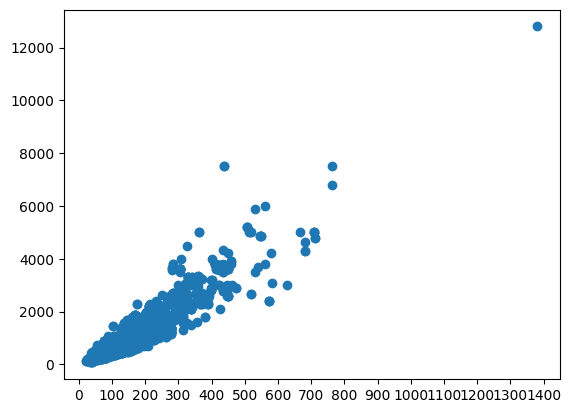

In [33]:
import matplotlib.pyplot as plt
area = data['建筑面积']
price = data['房屋总价']
plt.scatter(area,price)
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400])
plt.show() # 有离群点数据，对线性分析不利，需要过滤

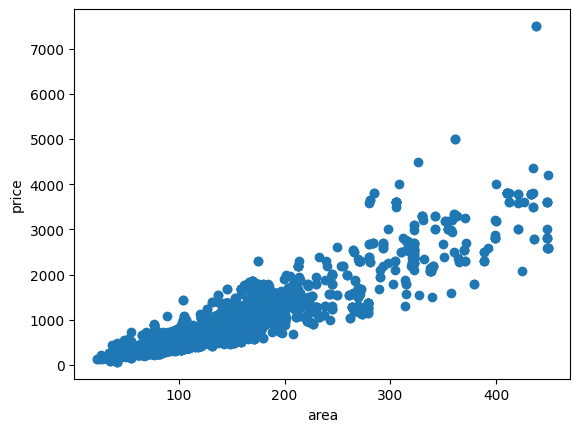

In [34]:
df = data[data['建筑面积'] <=450] # 正常去买二手住宅的面积小于等于400平米
area = df['建筑面积']
price = df['房屋总价']
#print(area.count()) #过滤后的数据量
plt.scatter(area,price)
plt.xlabel("area")
plt.ylabel("price")
plt.show()

# 4、构建房价预测模型

In [35]:
# 先根据建筑面积和房屋总价训练模型（一元线性回归）
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
area = np.array(area).reshape(-1,1) 
price = np.array(price).reshape(-1,1)
# 训练模型
model = linear.fit(area,price)
# 打印截距和回归系数
print(model.intercept_, model.coef_)

[-267.84188853] [[8.14190991]]


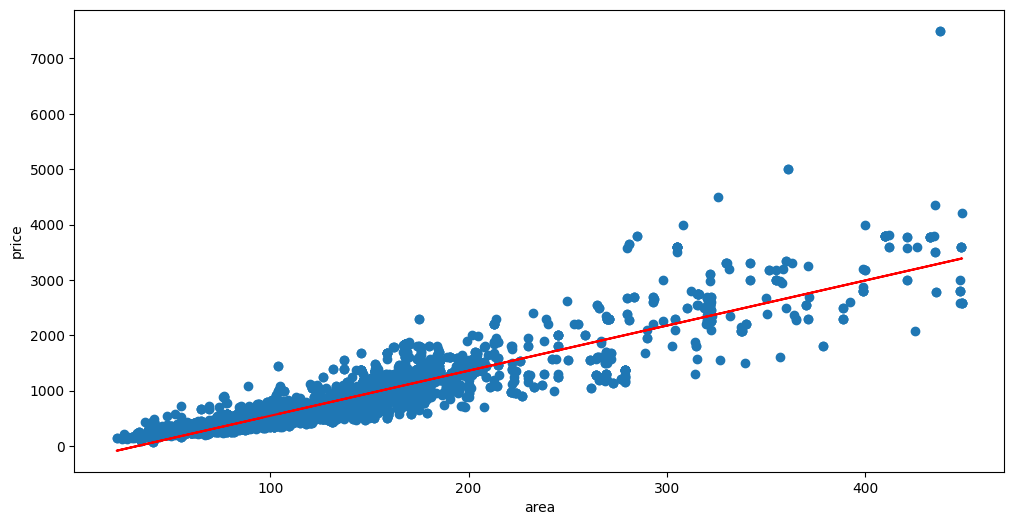

In [36]:
# 线性回归可视化(数据拟合)
linear_p = model.predict(area)
plt.figure(figsize=(12,6))
plt.scatter(area,price)
plt.plot(area,linear_p,'red')
plt.xlabel("area")
plt.ylabel("price")
plt.show()

### 多特征模型训练（多元线性回归）

In [37]:
cols = ['建筑面积','室', '厅', '卫', '东', '东北', '东南', '北', '南', '西',
       '西北', '西南', '低层', '高层', '毛坯', '简装修', '精装修', '豪华装修']

In [38]:
X = df[cols]
X.head()

,建筑面积,室,厅,卫,东,东北,东南,北,南,西,西北,西南,低层,高层,毛坯,简装修,精装修,豪华装修
0,104.58,2.0,2.0,2.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,201.61,5.0,2.0,2.0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,128.56,3.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,92.00,3.0,2.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,118.31,3.0,2.0,2.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [39]:
y = df['房屋总价']
y.head()

0     430.0
1    1280.0
2     750.0
3     430.0
4     520.0
Name: 房屋总价, dtype: float64

In [40]:
print(type(X))
print(type(y))
# 使用train_test_split进行交叉验证
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=12)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(4565, 18) (4565,)
(1142, 18) (1142,)


In [41]:
# 模型训练
linear = LinearRegression()
model = linear.fit(x_train,y_train)
print(model.intercept_, model.coef_)

-265.74508421165774 [  7.31859185  41.37537688 -46.52583415  15.55571075  21.48554728
 -40.56011825 -12.26299534  73.95672491 108.13054057  42.2359638
 -15.49723673  43.95562709   6.5945172  -12.20243802 110.7596757
   2.73150414  38.62287291  85.07018545]


In [43]:
# 模型性能评分
price_end = model.predict(x_test)
score = model.score(x_test,y_test) 
print("模型得分：",score)

模型得分： 0.8265726708486572


### 使用多种特征组合都可以预测房价，那么怎么找出最佳组合，这里使用假设验证法，选出最佳特征组合

In [45]:
# 使用假设验证法，选出最佳特征组合
cols = ['建筑面积','室', '厅', '卫', '东', '东北', '东南', '北', '南', '西',
       '西北', '西南', '低层', '高层', '毛坯', '简装修', '精装修', '豪华装修']
import statsmodels.api as sm
Y = df['房屋总价']
X = df[cols]
X_ = sm.add_constant(X) #增加一列值为1的const列，保证偏置项的正常
#print(X_)
# 使用最小平方法
result = sm.OLS(Y,X_)
# 使用fit方法进行计算
summary = result.fit()
# 调用summary2方法打印出假设验证信息（性能指标）
summary.summary2() # R-squared:模型评分 AIC：组合完越小越好

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.832     
Dependent Variable: 房屋总价             AIC:                78890.7229
Date:               2024-06-19 16:14 BIC:                79017.0624
No. Observations:   5707             Log-Likelihood:     -39426.   
Df Model:           18               F-statistic:        1576.     
Df Residuals:       5688             Prob (F-statistic): 0.00      
R-squared:          0.833            Scale:              58824.    
--------------------------------------------------------------------
           Coef.    Std.Err.     t      P>|t|     [0.025     0.975] 
--------------------------------------------------------------------
const    -263.7502   16.8411  -15.6611  0.0000  -296.7651  -230.7352
建筑面积        7.3345    0.0986   74.3563  0.0000     7.1411     7.5279
室          39.3671    5.4534    7.2188  0.0000    28.6762    50.0579
厅         -46.8648    8.6204   -5.4365  0.0000   -63.7640   -29.9656
卫          18.8333    6.2455    3.0155  0.0026     6.5898    31.0768
东          14.2905   15.5649    0.9181  0.3586   -16.2226    44.8036
东北        -33.2050   20.8921   -1.5894  0.1120   -74.1614     7.7515
东南         -0.0956   12.7753   -0.0075  0.9940   -25.1400    24.9488
北          71.1742   22.7327    3.1309  0.0018    26.6095   115.7389
南         125.2218   12.7757    9.8016  0.0000   100.1766   150.2671
西          45.0119   30.0373    1.4985  0.1341   -13.8727   103.8965
西北        -19.0737   19.1848   -0.9942  0.3202   -56.6833    18.5358
西南         42.4743   16.1061    2.6372  0.0084    10.9003    74.0484
低层          6.4363    8.2261    0.7824  0.4340    -9.6901    22.5626
高层        -14.5341    7.6323   -1.9043  0.0569   -29.4963     0.4282
毛坯        101.3616   17.2189    5.8866  0.0000    67.6060   135.1172
简装修        -3.7063   10.0829   -0.3676  0.7132   -23.4727    16.0601
精装修        35.1205    9.9991    3.5124  0.0004    15.5185    54.7226
豪华装修       78.8137   14.9856    5.2593  0.0000    49.4363   108.1912
-------------------------------------------------------------------
Omnibus:            3952.537      Durbin-Watson:         1.988     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      294467.186
Skew:               2.596         Prob(JB):              0.000     
Kurtosis:           37.805        Condition No.:         1333      
===================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
[2] The condition number is large, 1.33e+03. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

In [46]:
import itertools

list1 = [1, 2,3, 4, 5,6,7,8,9,10,11,12,13,14,15,16] #特征超过16个将发生异常
list2 = []
for i in range(1, len(list1)+1):
    iter1 = itertools.combinations(list1, i)
    list2.append(list(iter1))
#print(list2)

In [47]:
import itertools
# 使用itertools，找出AIC最小值的特征组合作为模型训练的特征
# 寻找最小AIC值的特征组合
fileds = ['建筑面积','室', '厅', '卫', '东','北', '南', '西','低层', '高层', '毛坯', '简装修', '精装修', '豪华装修']
acis = {}
for i in range(1,len(fileds)+1):
    for virables in itertools.combinations(fileds,i): #从fileds中随机选择i个特征机型组合，返回的virables为元组类型
        x1 = sm.add_constant(df[list(virables)])
        x2 = sm.OLS(Y,x1)
        res = x2.fit()
        acis[virables] = res.aic # AIC评分越小越好

In [48]:
from collections import Counter
# 对字典进行统计
counter = Counter(acis)
# 降序选出AIC最小的10个数，也就是最佳特征组合
counter.most_common()[-10:] 

[(('建筑面积', '室', '厅', '卫', '东', '北', '南', '低层', '高层', '毛坯', '精装修', '豪华装修'),
  78892.13746134506),
 (('建筑面积', '室', '厅', '卫', '东', '北', '南', '西', '低层', '高层', '毛坯', '精装修', '豪华装修'),
  78891.92758395607),
 (('建筑面积', '室', '厅', '卫', '北', '南', '高层', '毛坯', '简装修', '精装修', '豪华装修'),
  78891.46772657051),
 (('建筑面积', '室', '厅', '卫', '北', '南', '西', '高层', '毛坯', '简装修', '精装修', '豪华装修'),
  78891.25470963233),
 (('建筑面积', '室', '厅', '卫', '北', '南', '低层', '高层', '毛坯', '精装修', '豪华装修'),
  78891.1662509894),
 (('建筑面积', '室', '厅', '卫', '北', '南', '西', '低层', '高层', '毛坯', '精装修', '豪华装修'),
  78891.02650635364),
 (('建筑面积', '室', '厅', '卫', '东', '北', '南', '高层', '毛坯', '精装修', '豪华装修'),
  78890.73013490594),
 (('建筑面积', '室', '厅', '卫', '东', '北', '南', '西', '高层', '毛坯', '精装修', '豪华装修'),
  78890.45196703674),
 (('建筑面积', '室', '厅', '卫', '北', '南', '高层', '毛坯', '精装修', '豪华装修'),
  78889.82881547361),
 (('建筑面积', '室', '厅', '卫', '北', '南', '西', '高层', '毛坯', '精装修', '豪华装修'),
  78889.62004099906)]

In [49]:
# 接下来使用AIC值最小的特征组合进行预测
col2 = ['建筑面积', '室', '厅', '东', '南', '高层', '毛坯', '精装修', '豪华装修']
X = df[col2]
y = df['房屋总价']
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13)
linear = LinearRegression()
model = linear.fit(x_train,y_train)
model.score(x_test,y_test) # 模型性能有所提高，但是提升的不明显，提升了0.01多

0.8370112972047685

# 5、房价的预测

现在我们可以根据给定的最佳特征组合进行预测房价

In [63]:
# 假设购买一个房子
my_house = [110,2,1,0,1,0,0,1,0] #根据col2特征
my_house = np.array(my_house).reshape(-1,1).T
#print(x_test)
model.predict(my_house)# 预测价格

d:\Python\Program\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([764.52515402])